# Waste Classification Dataset

Source: https://www.kaggle.com/techsash/waste-classification-data

Waste management is a big problem in our country. Most of the wastes end up in landfills. This leads to many issues like:
- Increase in landfills
- Eutrophication
- Consumption of toxic waste by animals
- Leachate
- Increase in toxins
- Land, water and air pollution

Dataset is divided into two classes:
- Organic
- Recyclable

Train data (85%) and Test data (15%)
- Training data - 22564 images
- Test data - 2513 images

# Import Library

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import load_files
import cv2

import matplotlib.pyplot as plt
params = {'figure.figsize': (20, 20),
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
plt.rcParams.update(params)

# Parameters

In [2]:
# Address of dataset
train_dir = 'waste_dataset/TRAIN/'
test_dir = 'waste_dataset/TEST/'

In [3]:
# Shape of images
IMG_WIDTH = 80
IMG_HEIGHT = 80
IMG_CHANNELS = 3

In [4]:
# Constants of model
BATCH_SIZE = 128
EPOCHS = 30
CLASSES = 2
VERBOSE = 1
VALIDATION_SPLIT = 0.15
OPTIMIZER = tf.keras.optimizers.Adam()

# Load Dataset

In [5]:
# Define paths of images
def load_dataset(path):
    data = load_files(path)
    filenames = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_names = np.array(data['target_names'])
    
    return filenames, targets, target_names

In [6]:
X_train_paths, y_train, target_names = load_dataset(train_dir)
X_test_paths, y_test, _ = load_dataset(test_dir)

In [7]:
X_train_paths[:10]

array(['waste_dataset/TRAIN/O/O_9238.jpg',
       'waste_dataset/TRAIN/O/O_12382.jpg',
       'waste_dataset/TRAIN/O/O_11805.jpg',
       'waste_dataset/TRAIN/O/O_10685.jpg',
       'waste_dataset/TRAIN/O/O_5037.jpg',
       'waste_dataset/TRAIN/R/R_7478.jpg',
       'waste_dataset/TRAIN/R/R_3988.jpg',
       'waste_dataset/TRAIN/R/R_1810.jpg',
       'waste_dataset/TRAIN/R/R_9310.jpg',
       'waste_dataset/TRAIN/R/R_4042.jpg'], dtype='<U33')

In [8]:
y_train[:10]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [9]:
print('Training set size : ', X_train_paths.shape[0])
print('Testing set size : ', X_test_paths.shape[0])

Training set size :  22564
Testing set size :  2513


In [10]:
# Convert image to array (RGB)
def convert_image_to_array(file_paths):
    images_data = np.empty((file_paths.shape[0], IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
    for index, file in enumerate(file_paths):
        img = cv2.imread(file) 
        res = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        images_data[index] = res
        
    return images_data

In [11]:
X_train = np.array(convert_image_to_array(X_train_paths))
print('Training set images shape : ', X_train.shape)
print('Training set labels shape : ', y_train.shape)

X_test = np.array(convert_image_to_array(X_test_paths))
print('Test set images shape : ', X_test.shape)
print('Test set labels shape : ', y_test.shape)

Training set images shape :  (22564, 80, 80, 3)
Training set labels shape :  (22564,)
Test set images shape :  (2513, 80, 80, 3)
Test set labels shape :  (2513,)


# Visualizing Data (On Training Set)

### Images Data (Show random 24 images)

In [12]:
list_images = list()
for index in range(1, 2400, 100):
    list_images.append(index)

In [13]:
def show_images(list_images):
    fig = plt.figure()
    fig.subplots_adjust(top=1.2)
    classes = ['Organic', 'Recyclable']
    for c, value in enumerate(list_images, 1):
        c = fig.add_subplot(6, 4, c)
        c.imshow(X_train[value])
        c.set_title(classes[int(y_train[value])])

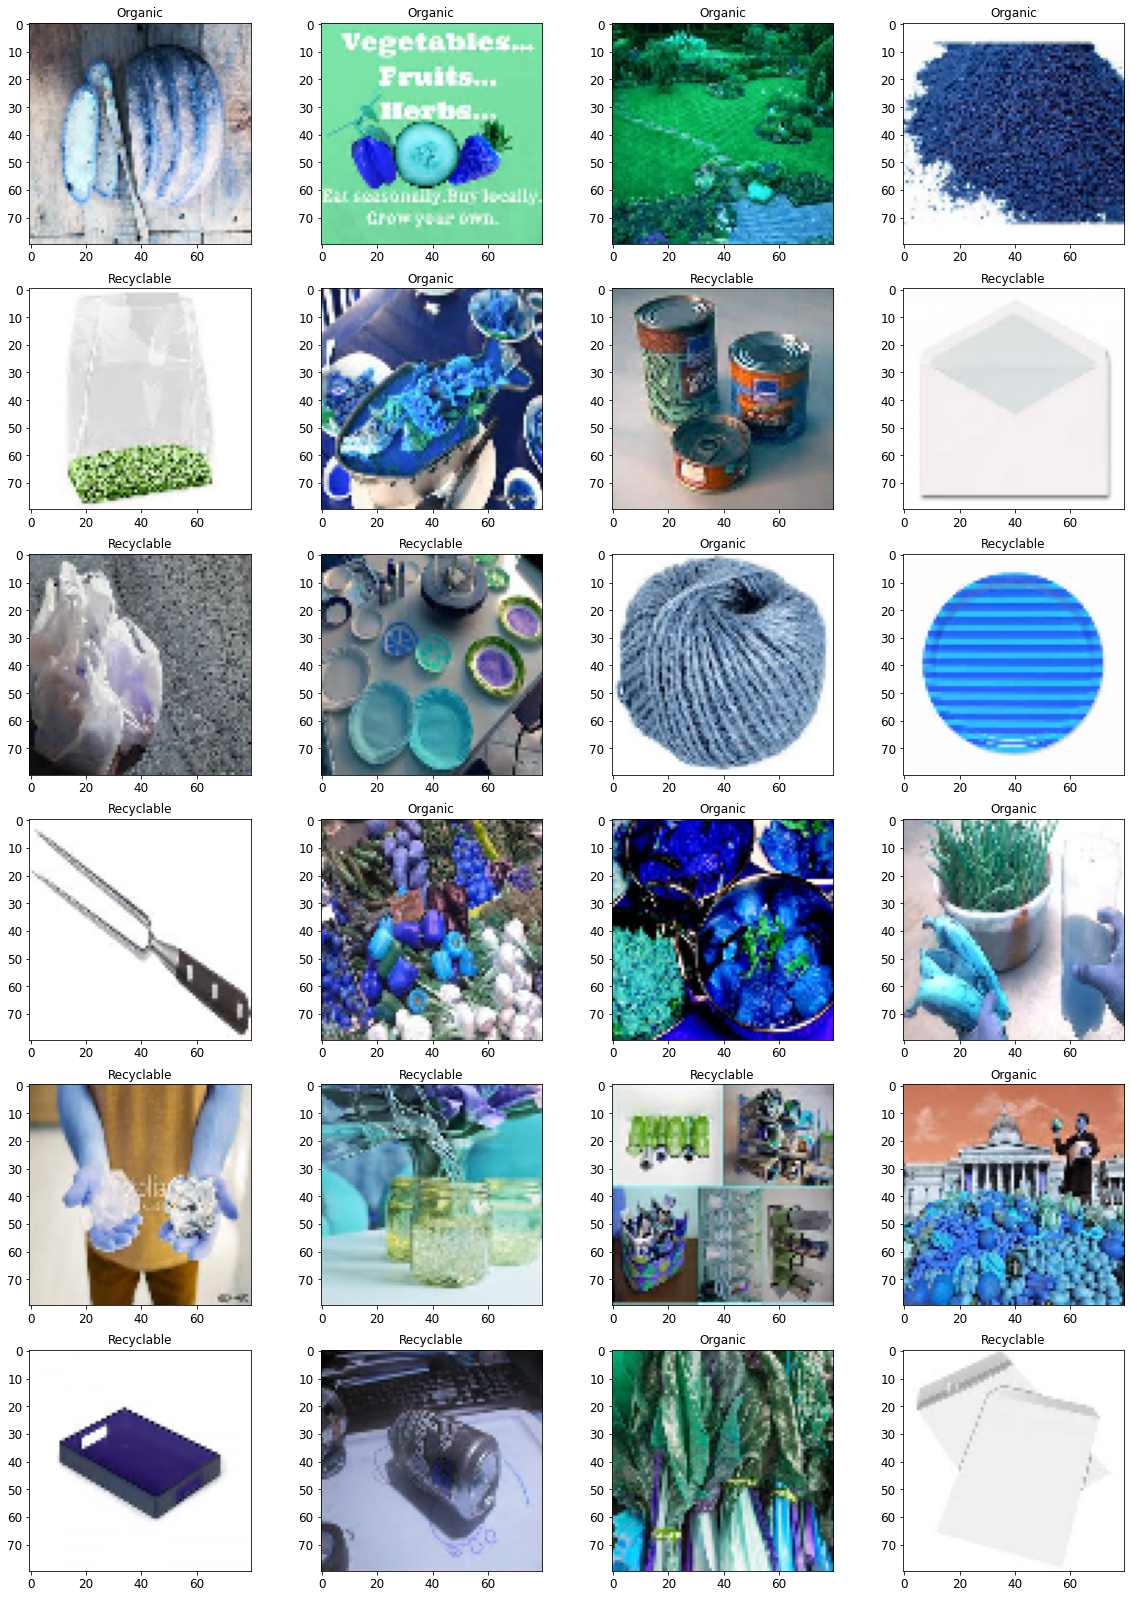

In [14]:
show_images(list_images)

### Labels Data

In [15]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the Test Data:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the Test Data:
[[    0     1]
 [12565  9999]]


In [16]:
labels = ['Organic', 'Recyclable']
sizes = np.asarray(counts_elements)

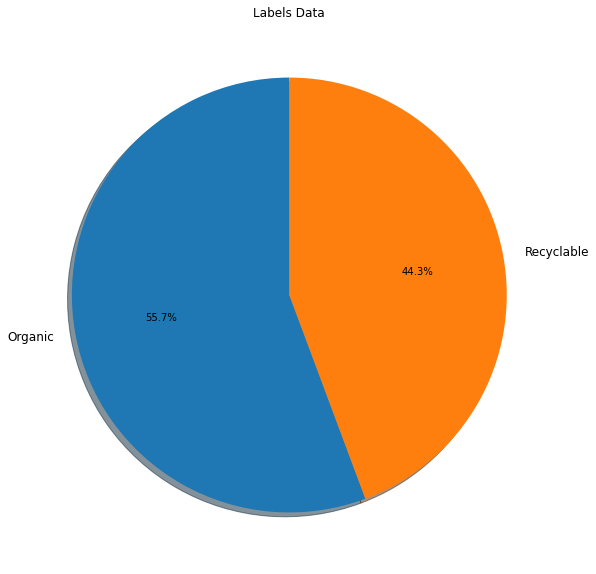

In [17]:
fig1 = plt.figure(figsize=[10, 10])
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Labels Data")
plt.show()

# Scale Data

In [18]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

#### Normalize Data
For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

It is valid for images to have pixel values in the range 0-1 and images can be viewed normally.

This can be achieved by dividing all pixels values by the largest pixel value; that is 255. This is performed across all channels, regardless of the actual range of pixel values that are present in the image.

In [19]:
X_train /= 255.0
X_test /= 255.0

#### Global Centering
A popular data preparation technique for image data is to subtract the mean value from the pixel values.

This approach is called centering, as the distribution of the pixel values is centered on the value of zero.

Centering can be performed before or after normalization. Centering the pixels then normalizing will mean that the pixel values will be centered close to 0.5 and be in the range 0-1. Centering after normalization will mean that the pixels will have positive and negative values, in which case images will not display correctly (e.g. pixels are expected to have value in the range 0-255 or 0-1). Centering after normalization might be preferred, although it might be worth testing both approaches.

Centering requires that a mean pixel value be calculated prior to subtracting it from the pixel values. There are multiple ways that the mean can be calculated; for example:

- Per image.
- Per mini-batch of images (under stochastic gradient descent).
- Per training dataset.

The mean can be calculated for all pixels in the image, referred to as a global centering, or it can be calculated for each channel in the case of color images, referred to as local centering.

- Global Centering: Calculating and subtracting the mean pixel value across color channels.
- Local Centering: Calculating and subtracting the mean pixel value per color channel.

In [20]:
mean_train = X_train.mean()
X_train -= mean_train

mean_test = X_test.mean()
X_test -= mean_test

# Building Model

In [21]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, CLASSES)

In [22]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Model
- 1st module: (CONV + CONV + MaxPool + DropOut)
- 2nd module: (CONV + CONV + MaxPool + DropOut)
- 3rd module: (CONV + CONV + MaxPool + DropOut)

In [23]:
# define the convnet
def build_model():
    model = models.Sequential()
    
    # 1st block
    model.add(layers.Conv2D(8, kernel_size=(3, 3), padding='same', input_shape=X_train.shape[1:], activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(layers.Dropout(0.2))
    
    # 2nd block
    model.add(layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(layers.Dropout(0.2))
    
    # 3rd block
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(layers.Dropout(0.2))
    
    # dense
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(CLASSES, activation='softmax'))
    return model

# initialize the optimizer and model
model = build_model()
model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 8)         224       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 8)         584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 16)        1

In [24]:
# use TensorBoard
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/second_model/')]

# fit
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT, callbacks=callbacks)

Epoch 1/30
150/150 [==============================] - 293s 2s/step - loss: 0.6794 - accuracy: 0.7137 - val_loss: 0.8610 - val_accuracy: 0.4393
Epoch 2/30
150/150 [==============================] - 299s 2s/step - loss: 0.4926 - accuracy: 0.7695 - val_loss: 0.6786 - val_accuracy: 0.5846
Epoch 3/30
150/150 [==============================] - 294s 2s/step - loss: 0.4302 - accuracy: 0.8102 - val_loss: 0.6853 - val_accuracy: 0.6632
Epoch 4/30
150/150 [==============================] - 292s 2s/step - loss: 0.4167 - accuracy: 0.8184 - val_loss: 0.5146 - val_accuracy: 0.7722
Epoch 5/30
150/150 [==============================] - 298s 2s/step - loss: 0.4015 - accuracy: 0.8258 - val_loss: 0.5266 - val_accuracy: 0.7840
Epoch 6/30
150/150 [==============================] - 294s 2s/step - loss: 0.3909 - accuracy: 0.8318 - val_loss: 0.4352 - val_accuracy: 0.8260
Epoch 7/30
150/150 [==============================] - 293s 2s/step - loss: 0.3741 - accuracy: 0.8431 - val_loss: 0.4725 - val_accuracy: 0.8092

In [25]:
score = model.evaluate(X_test, y_test, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

79/79 [==============================] - 1s 16ms/step - loss: 0.2624 - accuracy: 0.9021

Test score: 0.26239606738090515
Test accuracy: 0.9021090269088745


### Summary

In [34]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


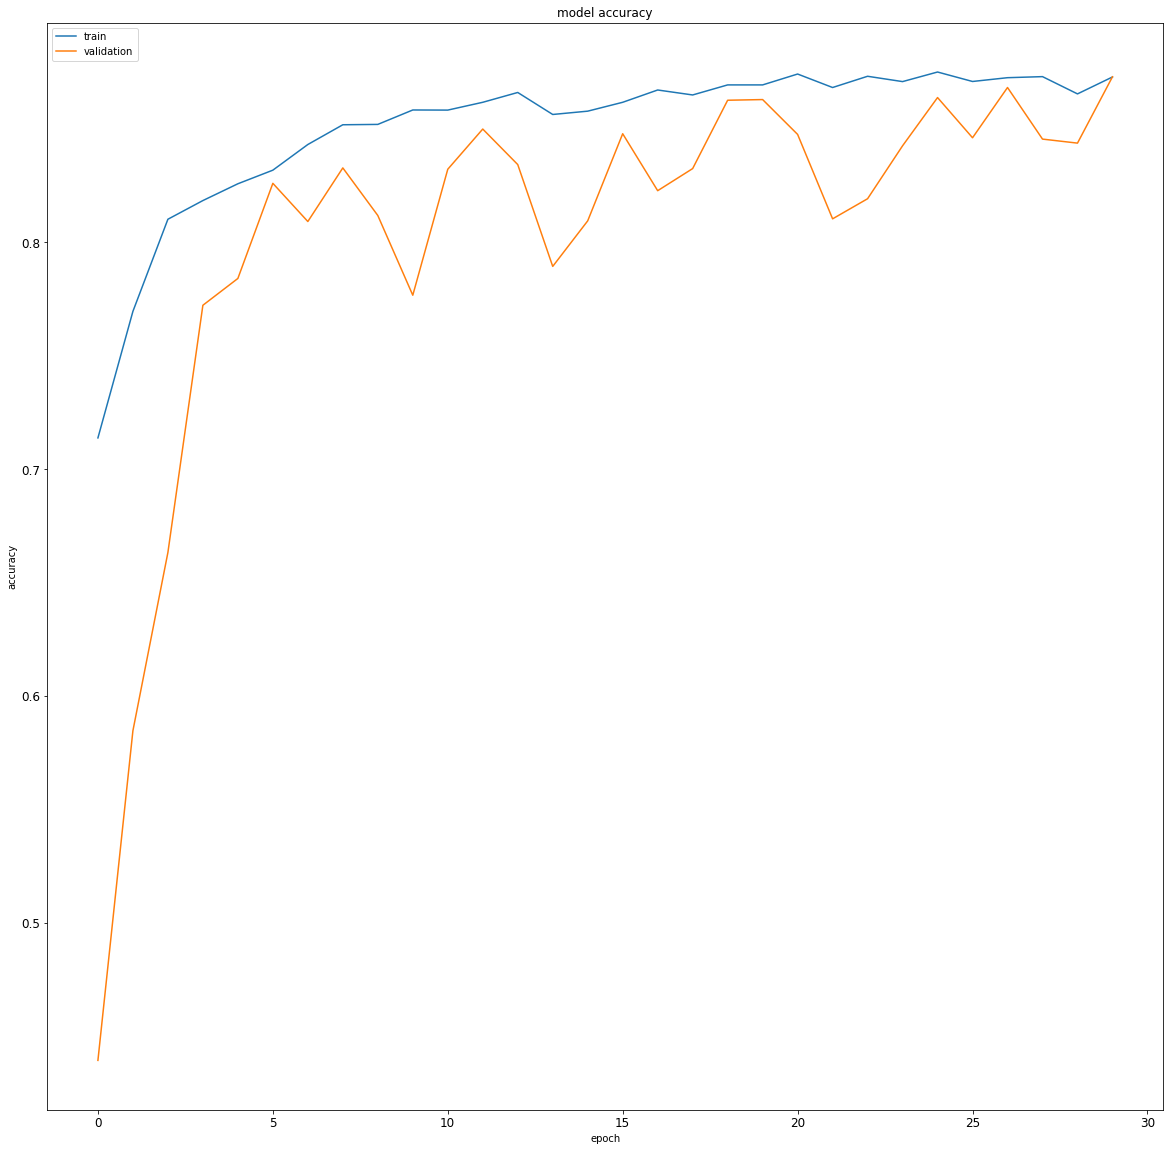

In [35]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

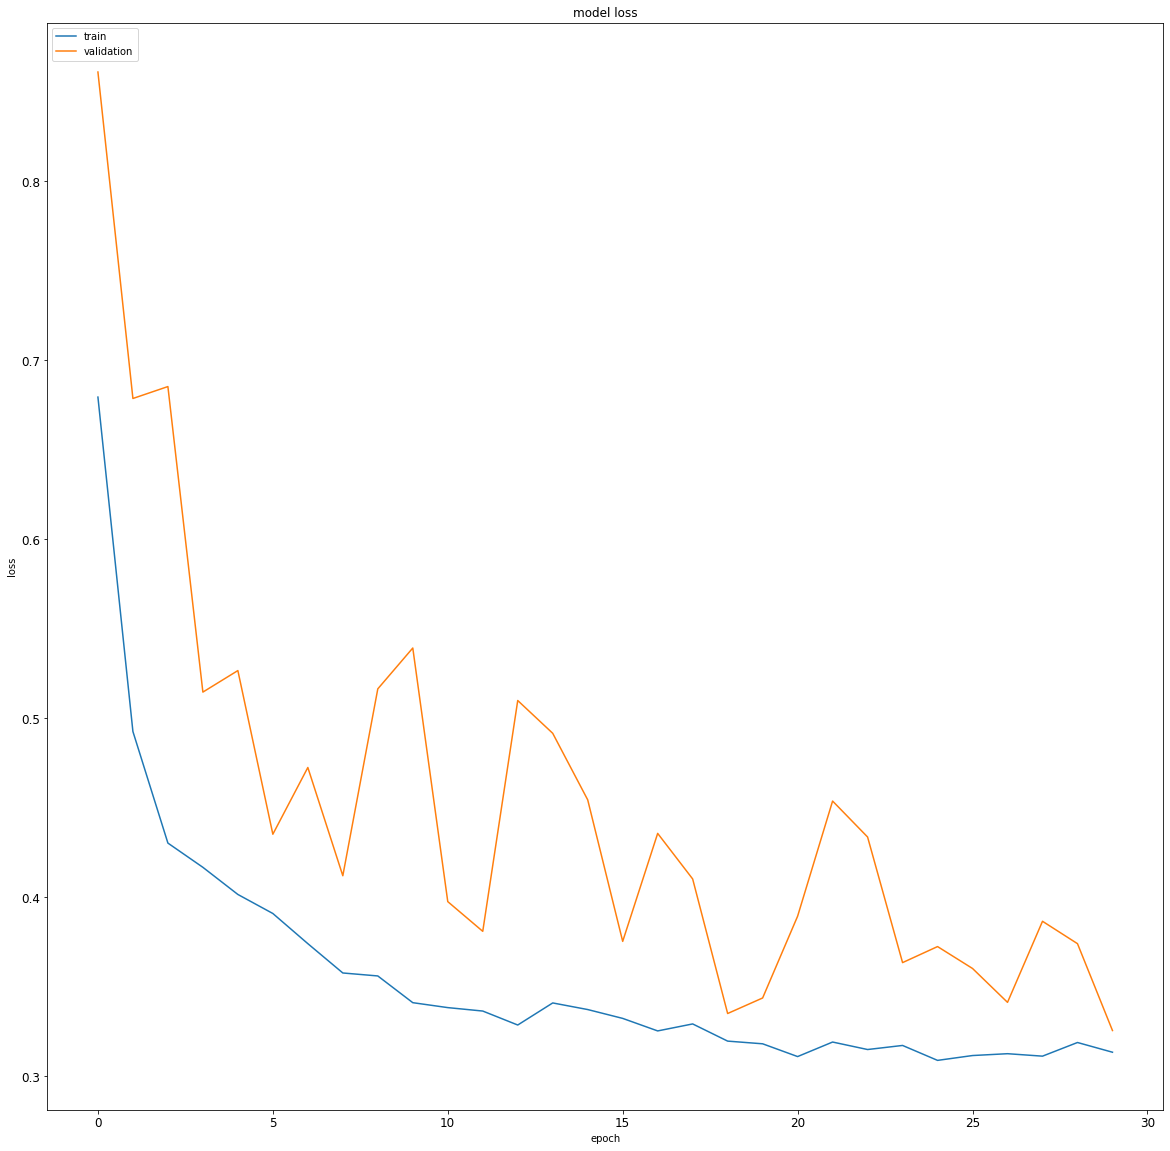

In [36]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Predicting

In [67]:
X_predict_paths = np.array(['Apple.jpg', 'Paper.jpg'])

In [68]:
X_predict = np.array(convert_image_to_array(X_predict_paths))
print('Predict set images shape : ', X_predict.shape)
images_pre = X_predict

Predict set images shape :  (2, 80, 80, 3)


In [69]:
X_predict = X_predict.astype(np.float32)
X_predict /= 255.0
mean_pre = X_predict.mean()
X_predict -= mean_pre

In [70]:
predictions = model.predict_classes(X_predict)

In [71]:
predictions

array([0, 1])

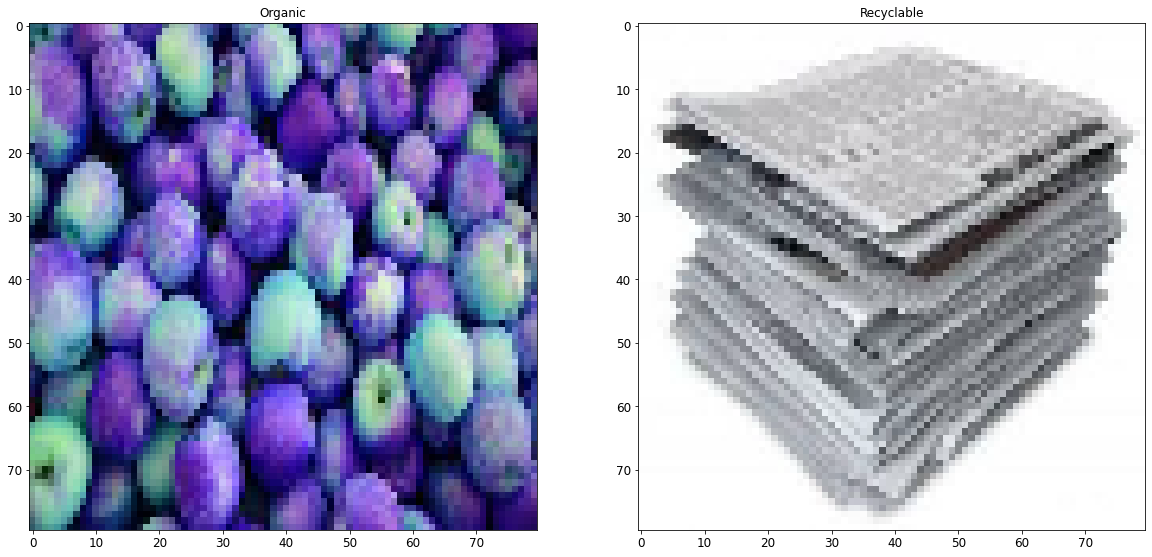

In [73]:
fig = plt.figure()
fig.subplots_adjust(top=1.2)
classes = ['Organic', 'Recyclable']
    
c1 = fig.add_subplot(1, 2, 1)
c1.imshow(images_pre[0])
c1.set_title(classes[predictions[0]])

c2 = fig.add_subplot(1, 2, 2)
c2.imshow(images_pre[1])
c2.set_title(classes[predictions[1]]);